# implement iterative identification of Ly$\alpha$ absorption

In [1]:
import os
import time
import pickle
import numpy as np

import torch
from torch import nn
from accelerate import Accelerator

import util as U
from spender import SpectrumAutoencoder
from spender.data import desi_qso as desi 

/home/chhahn/projects/spender_qso/bin/london/util.py:24: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _trapz_rebin(x, y, edges, results):


In [2]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
print("torch.cuda.device_count():",torch.cuda.device_count())

torch.cuda.device_count(): 1


In [4]:
niter = 2

In [5]:
def load_model(filename, models, instruments):
    device = instruments[0].wave_obs.device
    model_struct = torch.load(filename, map_location=device)
    #wave_rest = model_struct['model'][0]['decoder.wave_rest']
    
    for i, model in enumerate(models):
        # backwards compat: encoder.mlp instead of encoder.mlp.mlp
        if 'encoder.mlp.mlp.0.weight' in model_struct['model'][i].keys():
            from collections import OrderedDict
            model_struct['model'][i] = OrderedDict([(k.replace('mlp.mlp', 'mlp'), v) for k, v in model_struct['model'][i].items()])
        # backwards compat: add instrument to encoder
        try:
            model.load_state_dict(model_struct['model'][i], strict=False)
        except RuntimeError:
            model_struct['model'][i]['encoder.instrument.wave_obs']= instruments[i].wave_obs
            #model_struct['model'][i]['encoder.instrument.skyline_mask']= instruments[i].skyline_mask
            model.load_state_dict(model_struct[i]['model'], strict=False)

    losses = model_struct['losses']
    return models, losses

In [6]:
# define instruments
instruments = [ desi.DESI() ]

In [7]:
latents = 10 
z_min, z_max = 2.1, 3.5

# restframe wavelength for reconstructed spectra
# Note: represents joint dataset wavelength range
lmbda_min = instruments[0].wave_obs[0]/(1.0+z_max) # 2000 A
lmbda_max = instruments[0].wave_obs[-1]/(1.0+z_min) # 9824 A
bins = 9780
wave_rest = torch.linspace(lmbda_min, lmbda_max, bins, dtype=torch.float32)

# define and train the model
n_hidden = (64, 256, 1024)
models = [ SpectrumAutoencoder(instrument,
                               wave_rest,
                               n_latent=latents,
                               n_hidden=n_hidden,
                               act=[nn.LeakyReLU()]*(len(n_hidden)+1)
                               )
          for instrument in instruments ]

In [8]:
models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.rebin.iter%i.pt' % niter, models, instruments)

In [9]:
ibatch = 0 
with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)

In [10]:
with torch.no_grad():
    models[0].eval()
    instruments[0].eval()

    s = models[0].encode(spec)
    spec_rest = models[0].decode(s)

In [11]:
true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))

# 1. identify bad reconstructions 

In [12]:
def good_recon(wobs, fobs, iobs, wmod, fmod, zred, thresholds=15, verbose=False): 
    ''' determine whether a reconstruction is good or not
    '''
    wlim = wobs > 1300 * (1 + zred)
    try: 
        fmod_rebin = U.trapz_rebin(wmod, fmod, xnew=wobs)
        rchi2 = np.sum(((fobs - fmod_rebin)**2 * iobs)[wlim])/np.sum(wlim)
    except ValueError: 
        fmod_rebin = U.trapz_rebin(wmod, fmod, xnew=wobs[:-1])
        rchi2 = np.sum(((fobs[:-1] - fmod_rebin)**2 * iobs[:-1])[wlim[:-1]])/np.sum(wlim[:-1])
    if verbose: print(rchi2)
    if rchi2 < thresholds: return True
    else: return False
    
    #w_coarse = np.linspace(1300 * (1 + zred), 9000, 100)
    
    #fobs_rebin = U.trapz_rebin(wobs, fobs, xnew=w_coarse)
    #fmod_rebin = U.trapz_rebin(wmod, fmod, xnew=w_coarse)
    #metric = np.sum((fobs_rebin - fmod_rebin)**2)/float(len(w_coarse))
    #
    #if verbose: print('rchi2, metric', rchi2, metric)
    #if (rchi2 < thresholds[0]) and (metric < thresholds[1]): 
    #    return True
    #else: 
    #    return False

In [13]:
good_spender = [] 
for igal in range(spec.shape[0]):
    # check for reconstruction accuracy
    good_spender.append(good_recon(np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), 
                                   np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]),   
                                   z[igal].item(), thresholds=10, verbose=False))
good_spender = np.array(good_spender)

In [14]:
np.sum(~good_spender)

0

# 2. identify LyA forest

In [15]:
def identify_LyA(wobs, fobs, iobs, zobs, wmod, fmod, sigma=2, method='rebin', verbose=False):
    ''' identify wavelengths with LyA absorption based on a reconstructed spectra.



    '''
    w_lya = 1215.67 * (1. + zobs) # observed wavelength of LyA

    if method == 'rebin':
        # identify LyA regions after rebinning the observed spectra

        # rebin to coarser wavelength
        w_coarse = wobs[::5]
        # observed flux and ivar coarse binned
        fobs_coarse = U.trapz_rebin(wobs, fobs, edges=w_coarse)
        ivar_coarse = U.trapz_rebin(wobs, iobs/np.gradient(wobs), edges=w_coarse) * (w_coarse[1:] - w_coarse[:-1])
        # reconstructed flux coarse binned
        fmod_coarse = U.trapz_rebin(wmod, fmod, edges=w_coarse)

        is_absorb_coarse = np.zeros(len(w_coarse)-1).astype(bool)

        # below LyA
        below_lya = (w_coarse[1:] < w_lya)
        is_absorb_coarse[below_lya] = (fmod_coarse[below_lya] - fobs_coarse[below_lya] > sigma * ivar_coarse[below_lya]**-0.5)
        # above LyA (more conservative 3 sigma clipping)
        is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * ivar_coarse[~below_lya]**-0.5)

        is_absorb = np.zeros(len(wobs)).astype(bool)
        is_absorb[:-4][::5] = is_absorb_coarse
        is_absorb[1:-3][::5] = is_absorb_coarse
        is_absorb[2:-2][::5] = is_absorb_coarse
        is_absorb[3:-1][::5] = is_absorb_coarse
        is_absorb[4:][::5] = is_absorb_coarse
    else:
        raise NotImplementedError

    return is_absorb

<ipython-input-15-7eccb29a0609>:24: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[below_lya] = (fmod_coarse[below_lya] - fobs_coarse[below_lya] > sigma * ivar_coarse[below_lya]**-0.5)
<ipython-input-15-7eccb29a0609>:26: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * ivar_coarse[~below_lya]**-0.5)
<ipython-input-16-059a33f9a883>:14: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  sub.scatter(models[0].wave_obs[(w[igal] == 0) | is_absorb], spec[igal][(w[igal] == 0) | is_absorb], c='C1', s=2)


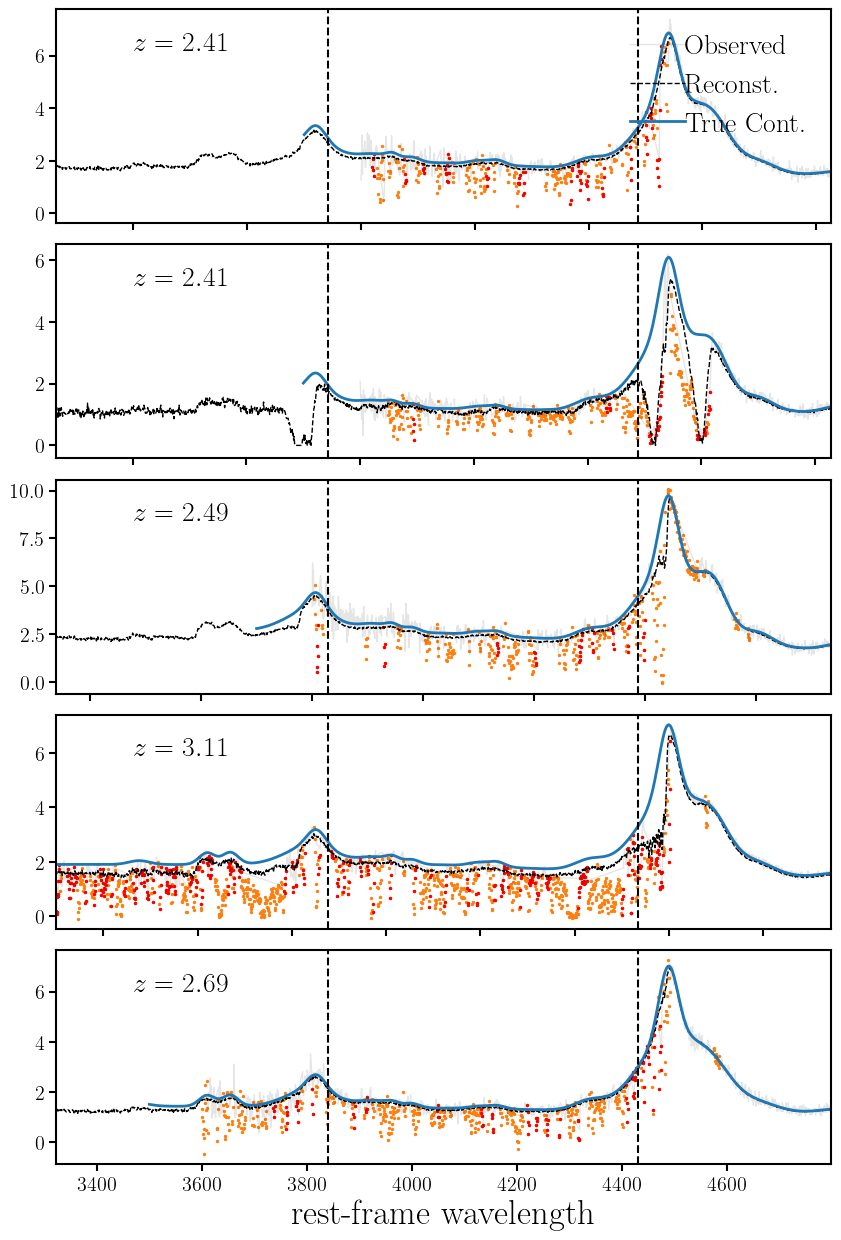

In [16]:
fig = plt.figure(figsize=(10,15))
for ii, igal in enumerate(np.random.choice(np.arange(len(spec))[np.array(norm) > 4.], size=5, replace=False)): 
    sub = fig.add_subplot(5,1,ii+1)
    
    sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
    sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='k', lw=1, ls='--', label='Reconst.')
    sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')
    
    is_absorb = identify_LyA(
        np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
        np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), sigma=1.5, method='rebin')
    
    #sub.scatter(models[0].wave_obs[(w[igal] > 0) & ~is_absorb], spec[igal][(w[igal] > 0) & ~is_absorb], c='k', s=1)    
    sub.scatter(models[0].wave_obs[(w[igal] == 0) | is_absorb], spec[igal][(w[igal] == 0) | is_absorb], c='C1', s=2)
    sub.scatter(models[0].wave_obs[is_absorb], spec[igal][is_absorb], c='r', s=2)
    
    sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
    sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')

    sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)

    sub.set_xlim(900 * (1+z[igal]), 1300. * (1+z[igal]))
    if ii < 4: sub.set_xticklabels([])
    if ii == 0: sub.legend(loc='upper right', fontsize=20, handletextpad=0)
sub.set_xlabel("rest-frame wavelength", fontsize=25)
fig.subplots_adjust(hspace=0.1)
plt.show()

# 3. deploy on batches

BATCH 0
tensor(1.3395e+08)


<ipython-input-15-7eccb29a0609>:24: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[below_lya] = (fmod_coarse[below_lya] - fobs_coarse[below_lya] > sigma * ivar_coarse[below_lya]**-0.5)
<ipython-input-15-7eccb29a0609>:26: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * ivar_coarse[~below_lya]**-0.5)
<ipython-input-16-3a547899ff11>:43: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  sub.plot(models[0].wave_obs[(w[igal] > 0) & ~is_absorb], spec[igal][(w[igal] > 0) & ~is_absorb], c='k', alpha=0.5, lw=1, label='Observed')
<ipython-input-16-3a547899ff11>:44: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  sub.scatter(models[0]

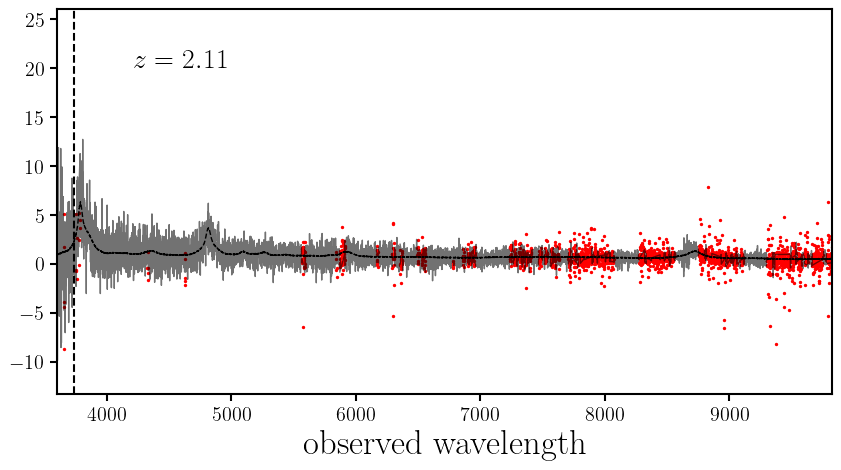

<ipython-input-15-7eccb29a0609>:26: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[~below_lya] = (fmod_coarse[~below_lya] - fobs_coarse[~below_lya] > 3 * ivar_coarse[~below_lya]**-0.5)
<ipython-input-15-7eccb29a0609>:24: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[below_lya] = (fmod_coarse[below_lya] - fobs_coarse[below_lya] > sigma * ivar_coarse[below_lya]**-0.5)


tensor(1.3268e+08)
BATCH 1
tensor(2.0089e+08)


<ipython-input-16-3a547899ff11>:43: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  sub.plot(models[0].wave_obs[(w[igal] > 0) & ~is_absorb], spec[igal][(w[igal] > 0) & ~is_absorb], c='k', alpha=0.5, lw=1, label='Observed')
<ipython-input-16-3a547899ff11>:44: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  sub.scatter(models[0].wave_obs[(w[igal] == 0) | is_absorb], spec[igal][(w[igal] == 0) | is_absorb], c='r', s=2)


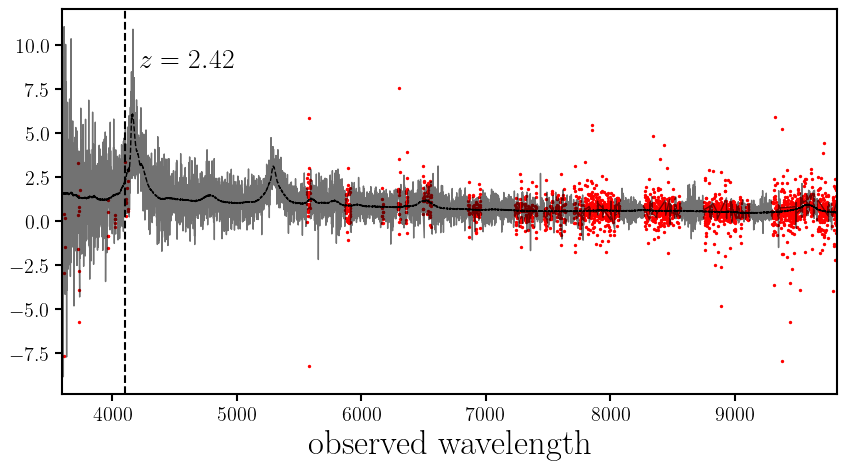

tensor(2.0039e+08)
BATCH 2
tensor(2.3407e+08)


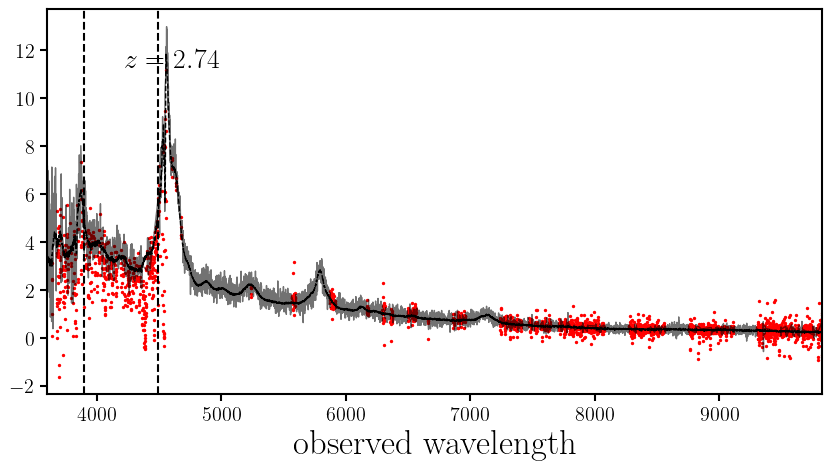

tensor(2.3382e+08)
BATCH 3
tensor(1.6621e+08)


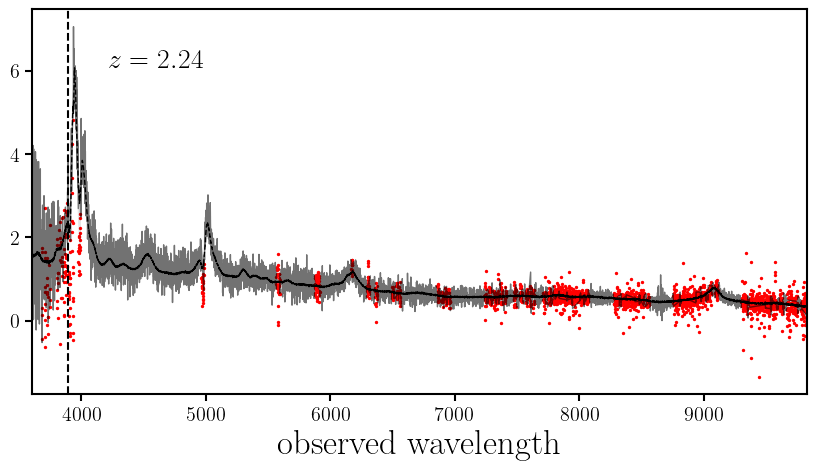

tensor(1.6609e+08)
BATCH 4
tensor(1.5233e+08)


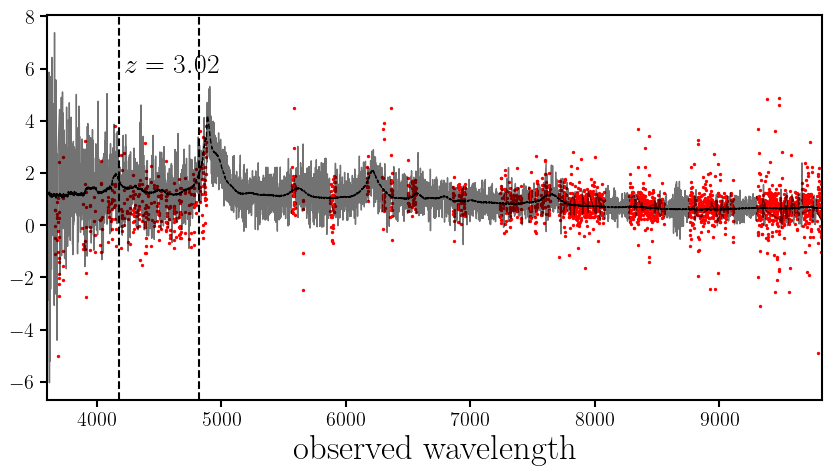

tensor(1.5220e+08)
BATCH 5
tensor(2.1525e+08)


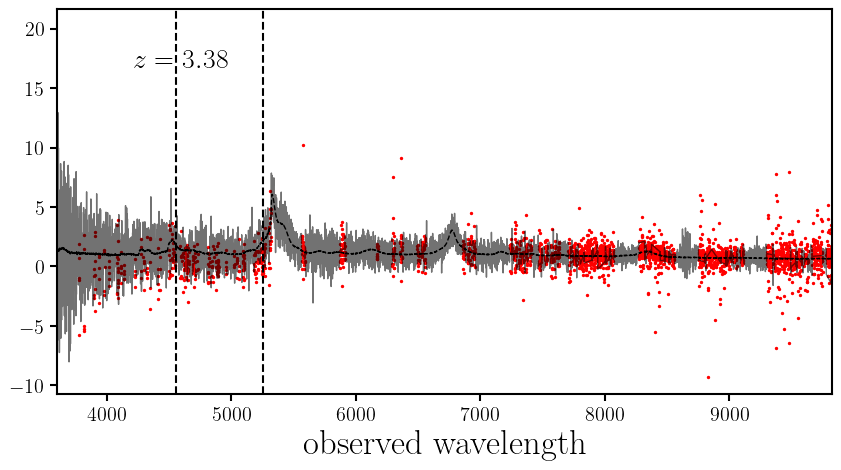

tensor(2.1487e+08)
BATCH 6
tensor(1.9437e+08)


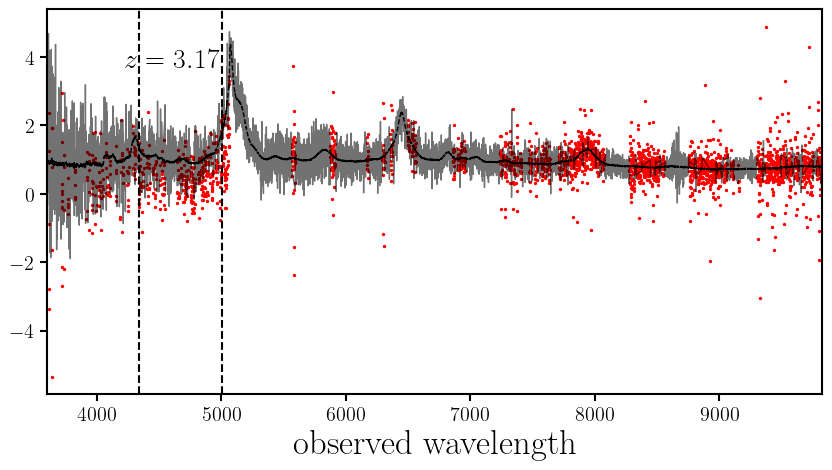

tensor(1.9420e+08)
BATCH 7
tensor(2.8045e+08)


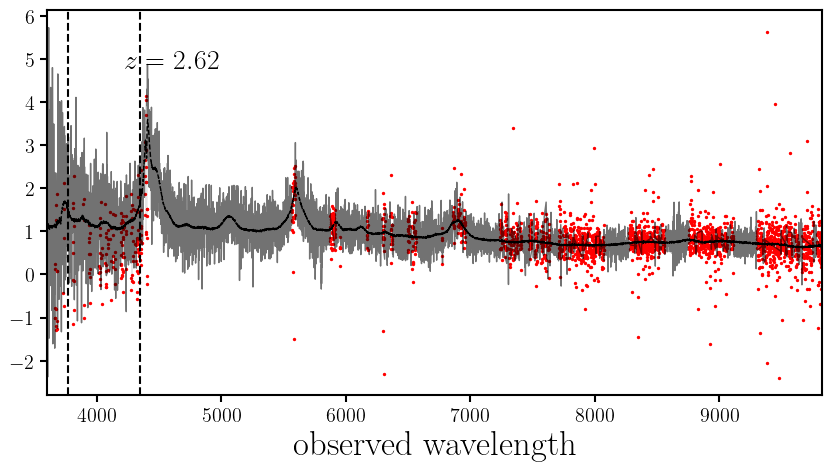

tensor(2.6338e+08)
BATCH 8
tensor(3.7070e+08)


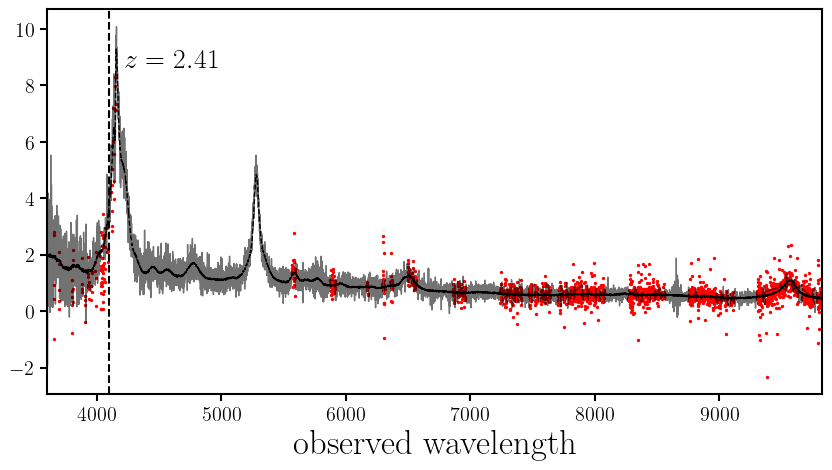

tensor(3.6901e+08)
BATCH 9
tensor(2.4731e+08)


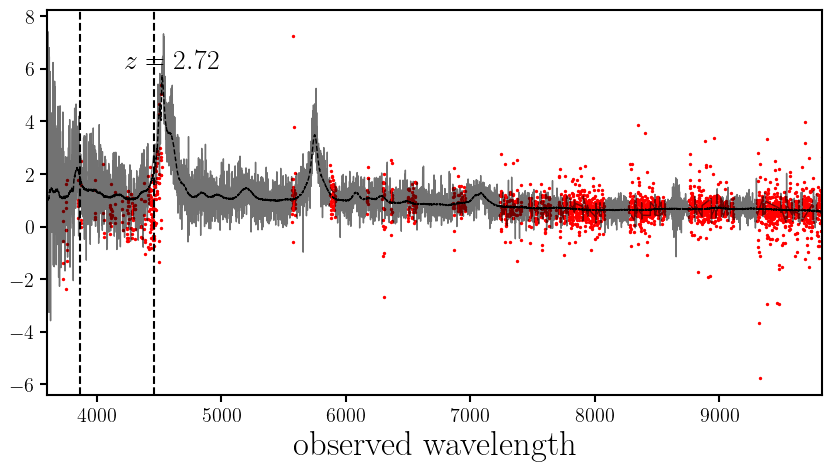

tensor(2.4289e+08)
BATCH 10
tensor(2.9651e+08)


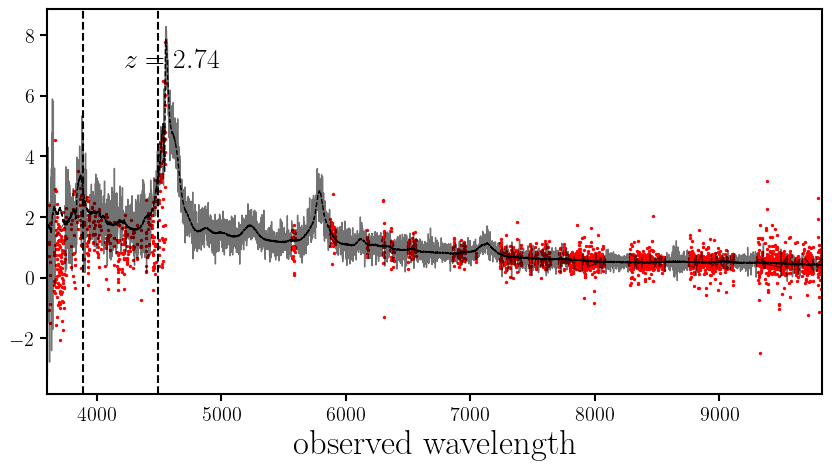

tensor(2.9588e+08)
BATCH 11
tensor(1.8075e+08)


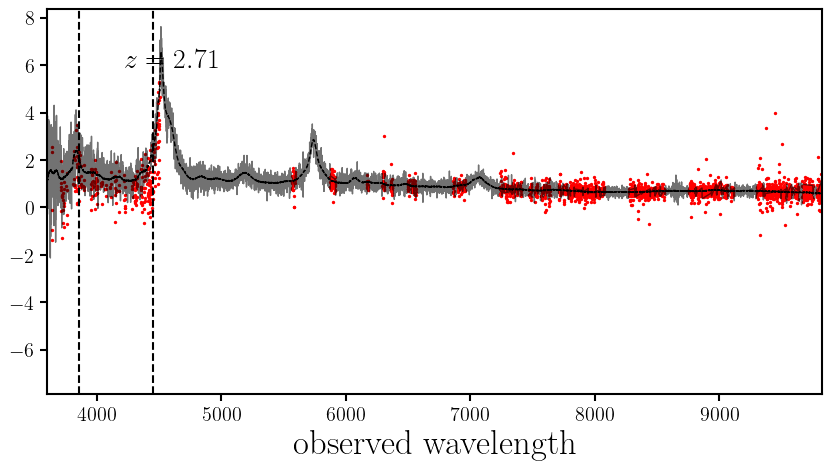

tensor(1.8048e+08)
BATCH 12
tensor(1.5070e+08)


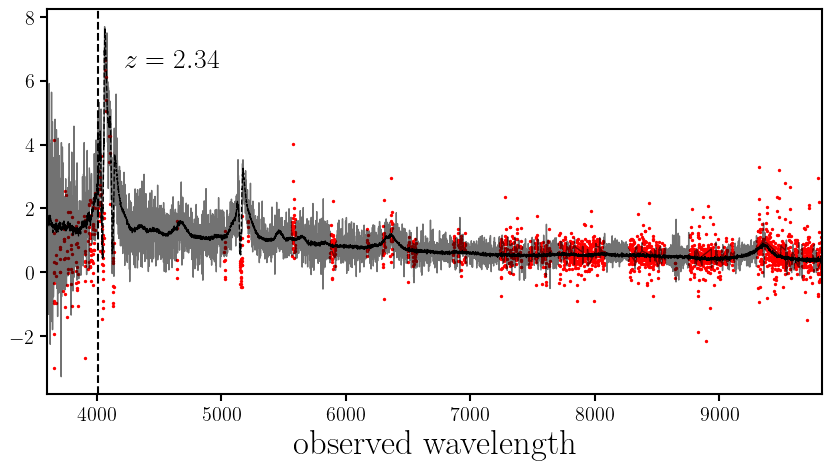

tensor(1.5051e+08)
BATCH 13
tensor(3.0403e+08)


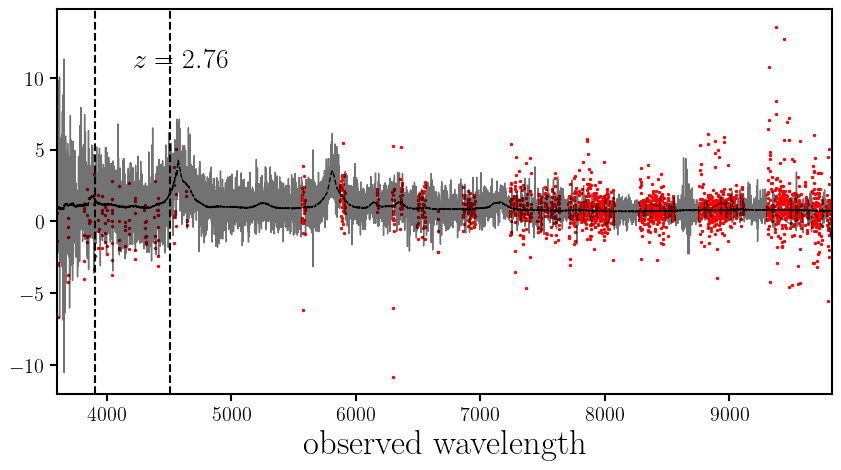

tensor(3.0018e+08)
BATCH 14
tensor(1.5900e+08)


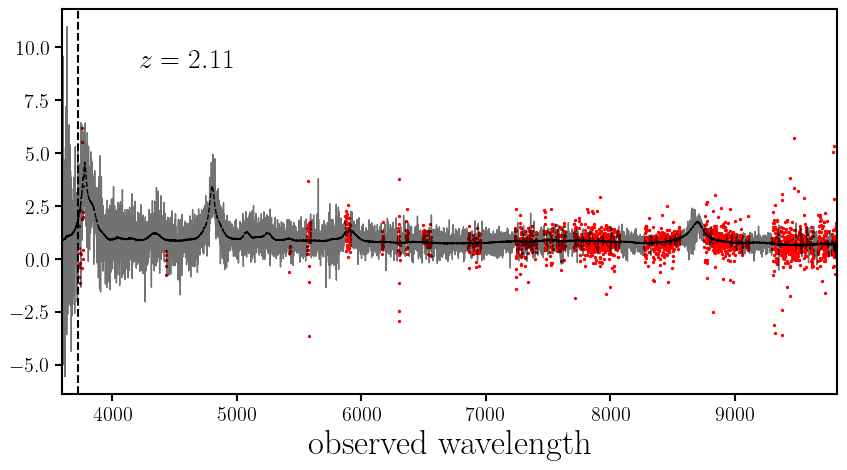

tensor(1.5888e+08)
BATCH 15
tensor(1.9329e+08)


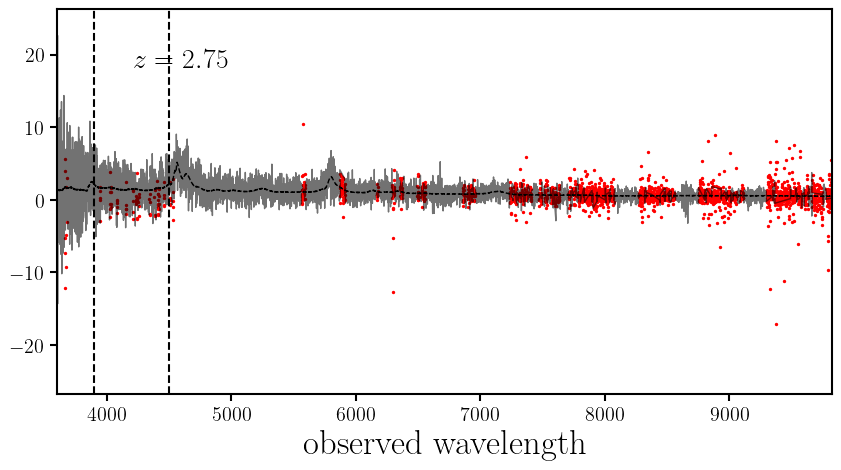

tensor(1.9314e+08)
BATCH 16
tensor(1.9609e+08)


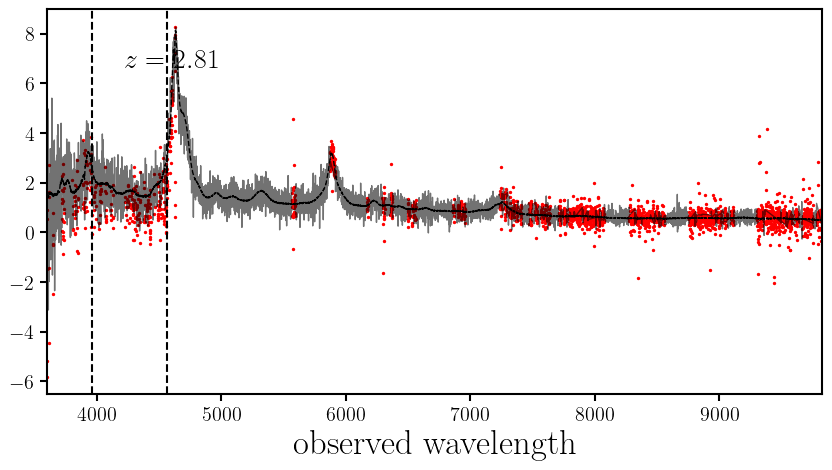

tensor(1.9560e+08)
BATCH 17
tensor(1.8430e+08)


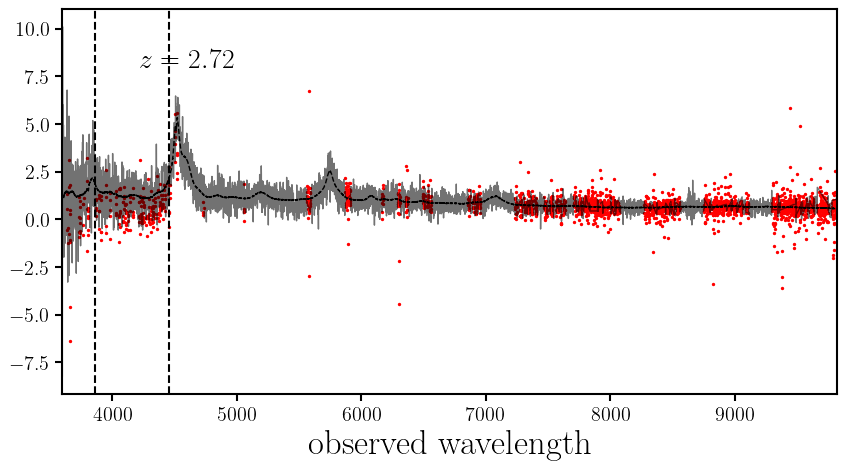

tensor(1.8404e+08)
BATCH 18
tensor(1.8930e+08)


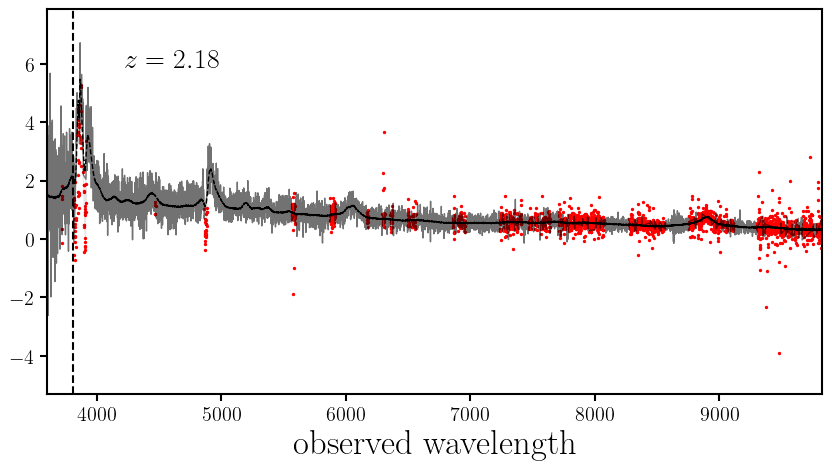

tensor(1.8914e+08)
BATCH 19
tensor(3.3471e+08)


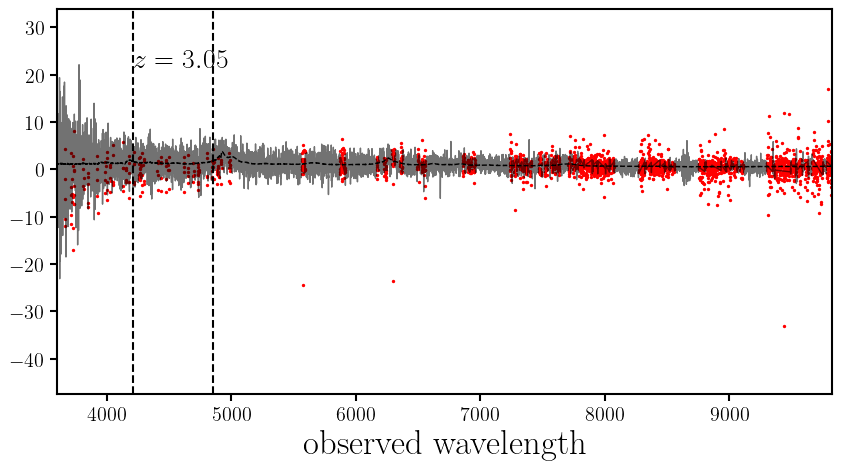

tensor(3.3411e+08)
BATCH 20
tensor(2.2494e+08)


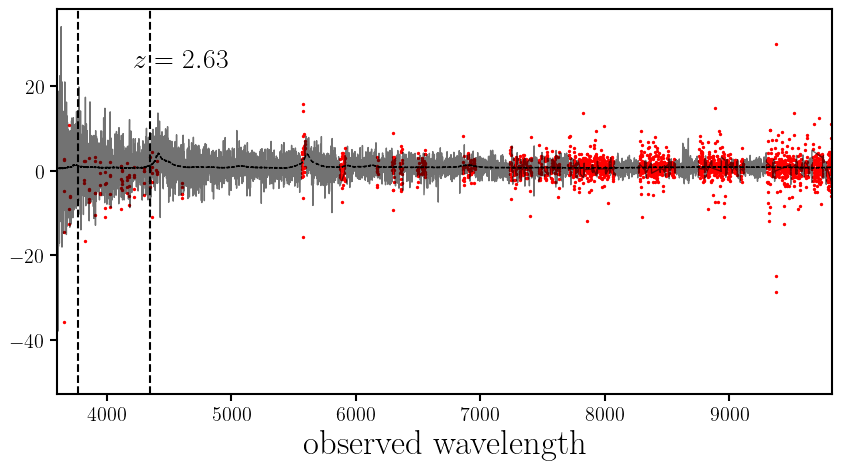

tensor(2.2438e+08)
BATCH 21
tensor(1.8008e+08)


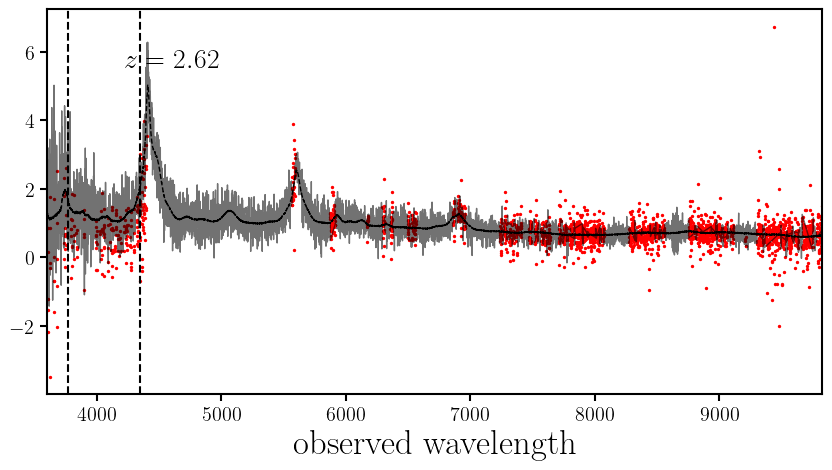

tensor(1.7957e+08)
BATCH 22
tensor(3.1286e+08)


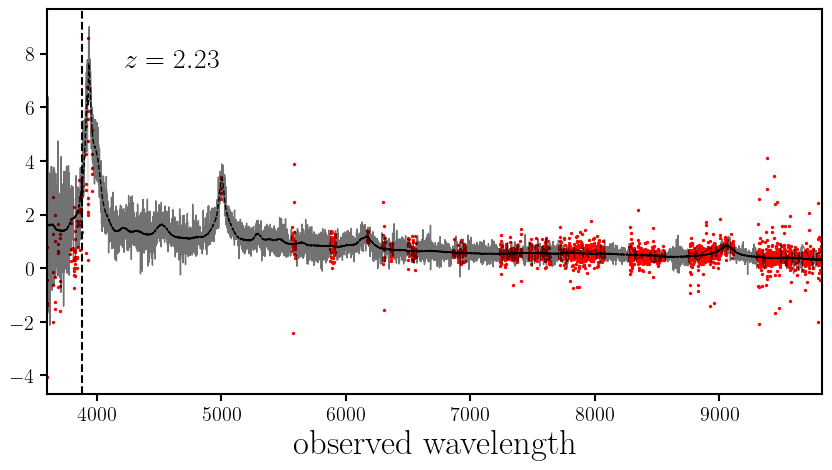

tensor(3.0890e+08)
BATCH 23
tensor(3.7112e+08)


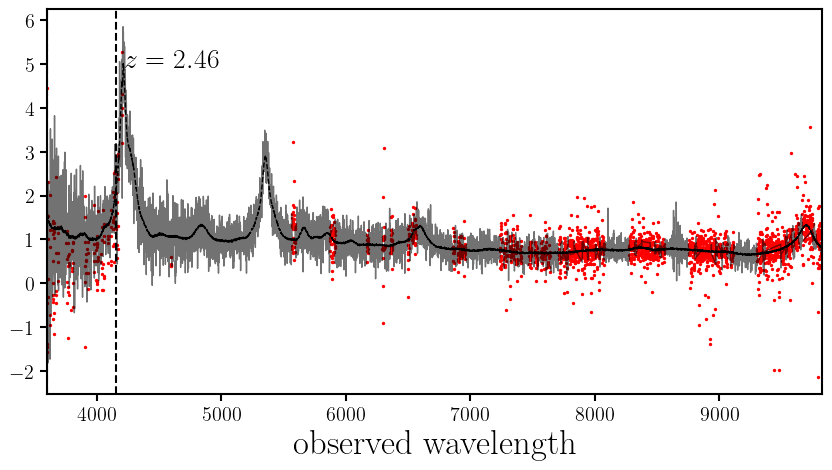

tensor(3.6900e+08)
BATCH 24


In [ ]:
for ibatch in range(100): 
    print('BATCH %i' % ibatch)
    with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
        spec, w, z, target_id, norm, zerr = pickle.load(f)
    
    if ibatch < 50: true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))
    
    with torch.no_grad():
        models[0].eval()
        instruments[0].eval()

        s = models[0].encode(spec)
        spec_rest = models[0].decode(s)
        
    # check for reconstruction accuracy
    #is_good = [] 
    #for igal in range(spec.shape[0]):
    #    if z[igal] > 3.499: # quick fix for some wavelength issue
    #        is_good.append(False)
    #        continue
    #    is_good.append(good_recon(np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), 
    #                                   np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]),   
    #                                   z[igal].item(), thresholds=[10, 0.1], verbose=False))
    #is_good = np.array(is_good)        
    #print(np.sum(~is_good))
    #if np.sum(is_good) == len(is_good): raise ValueError
    
    # identify clear absorption
    print(w.sum())
    for igal in np.arange(spec.shape[0]): #[is_good]: 
        is_absorb = identify_LyA(
            np.array(models[0].wave_obs), np.array(spec[igal]), np.array(w[igal]), np.array(z)[igal], 
            np.array(models[0].wave_rest * (1 + z[igal])), np.array(spec_rest[igal]), sigma=1.5)
        
        if igal == 100: 
            fig = plt.figure(figsize=(10,5))
            sub = fig.add_subplot(111)
            sub.plot(models[0].wave_obs[w[igal] > 0], spec[igal][w[igal] > 0], c='k', alpha=0.1, lw=1, label='Observed')    
            sub.plot(models[0].wave_rest * (1 + z[igal]), spec_rest[igal], color='k', lw=1, ls='--', label='Reconst.')
        
            #sub.plot(np.linspace(3.5e3, 1e4, 3251), true_cont[igal]/norm[igal], c='C0', lw=2, label='True Cont.')
    
            sub.plot(models[0].wave_obs[(w[igal] > 0) & ~is_absorb], spec[igal][(w[igal] > 0) & ~is_absorb], c='k', alpha=0.5, lw=1, label='Observed')    
            sub.scatter(models[0].wave_obs[(w[igal] == 0) | is_absorb], spec[igal][(w[igal] == 0) | is_absorb], c='r', s=2)
            
            sub.axvline(1040. * (1+z[igal]), linestyle='--', color='k')
            sub.axvline(1200. * (1+z[igal]), linestyle='--', color='k')

            sub.text(0.1, 0.9, '$z=%.2f$' % z[igal], ha='left', va='top', fontsize=20, transform=sub.transAxes)

            sub.set_xlim(models[0].wave_obs[0], models[0].wave_obs[-1])
    
            sub.set_xlabel("observed wavelength", fontsize=25)
            plt.show()
            
        # update weights
        w[igal,is_absorb] = 0.
    print(w.sum())
        
    batch = [spec, w, z, target_id, norm, zerr]
    with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter+1, ibatch), "wb") as f:
        pickle.dump(batch, f)